## Цель работы

Изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качества.

## Постановка задачи

Провести обучение модели линейной регрессии на датасете с Kaggle:

1. **Загрузка данных**  
   Загрузить датасет из репозитория (например, [kaggle.com](https://www.kaggle.com) или аналогичных платформ).

2. **Анализ данных**  
   Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной.

3. **Предобработка данных**  
   Провести предобработку данных:  
   - удалить пропущенные значения;  
   - закодировать категориальные переменные;  
   - нормализовать признаки;

4. **Анализ мультиколлинеарности**  
   Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчёт VIF-коэффициента).

5. **Построение регрессионных моделей**  
   Построить регрессионные модели:  
   - линейная регрессия;  
   - гребневая регрессия;  
   
   Если целевая переменная — категориальная, исследовать логистическую регрессию.  
   
   Разделить данные на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию.  
   
   Оценить качество построенной модели с помощью метрик:  
   - **RMSE** (Root Mean Square Error);  
   - **R²** (коэффициент детерминации);  
   - **MAPE** (Mean Absolute Percentage Error).

6. **Снижение размерности**  
   Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).

7. **Сравнение моделей**  
   Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты.  
   
   Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

### Установка библиотек

In [61]:
pip install pandas matplotlib seaborn scikit-learn statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Импорты библиотек

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import skew, kurtosis, mode
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV

### Чтение данных.

In [63]:
df  = pd.read_csv("Concrete Compressive Strength.csv")

### Первичный анализ.

In [64]:

print("Информация о данных:")
print(df.info())

print("\nСтатистическое описание:")
print(df.describe())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Cement                         1030 non-null   float64
 1   Blast Furnace Slag             1030 non-null   float64
 2   Fly Ash                        1030 non-null   float64
 3   Water                          1030 non-null   float64
 4   Superplasticizer               1030 non-null   float64
 5   Coarse Aggregate               1030 non-null   float64
 6   Fine Aggregate                 1030 non-null   float64
 7   Age (day)                      1030 non-null   int64  
 8   Concrete compressive strength  1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.6 KB
None

Статистическое описание:
            Cement  Blast Furnace Slag      Fly Ash        Water  \
count  1030.000000         1030.000000  1030.000000  1030.00000

В результате анализа данных мы видим, что датасет содержит 1030 записей, пропущенные значения отсутствуют, все представленные данные имеют числовой формат. Целевая переменная варьируется от 2.33 до 82.60, со средним значением около 35.8 и медианой 34.4, что указывает на умеренно симметричное распределение прочности.



### Построение гистограмм и их анализ.

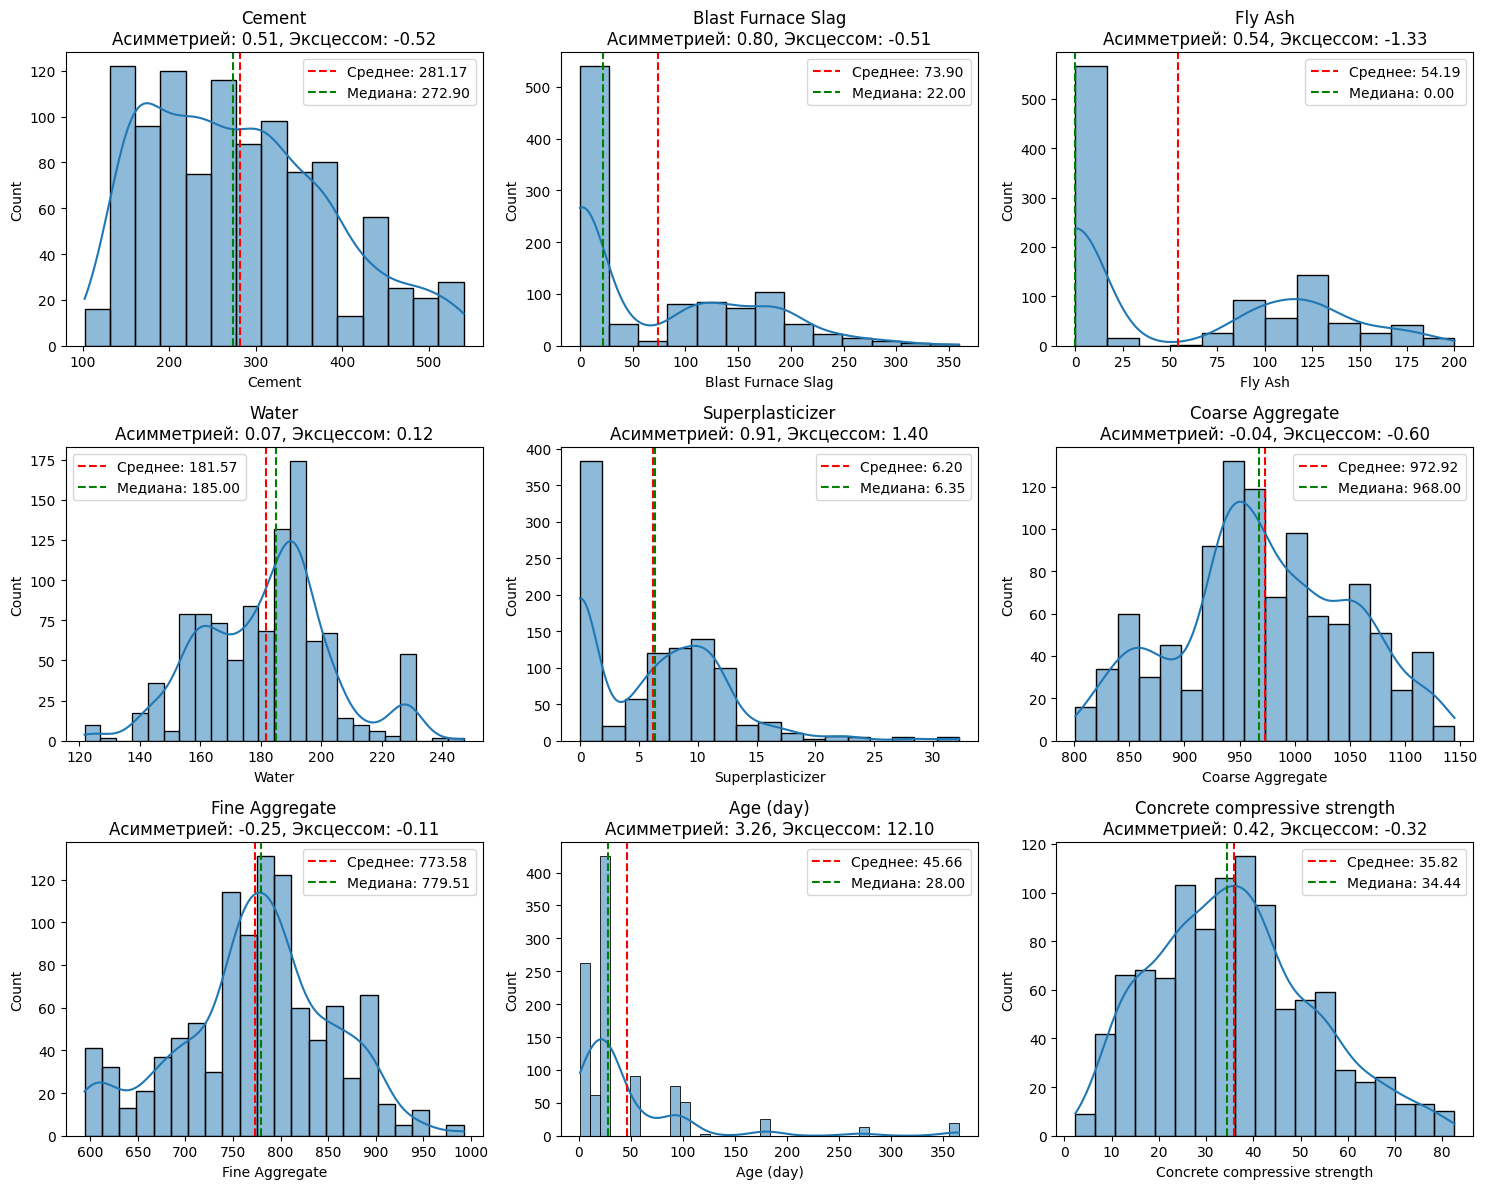

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(df.columns):
    data = df[col]
    
    mean_val = np.mean(data)
    median_val = np.median(data)
    skewness = skew(data)
    kurt = kurtosis(data)

    sns.histplot(data, ax=axes[i], kde=True)
    
    axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Среднее: {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Медиана: {median_val:.2f}')
    
    axes[i].set_title(f'{col}\nАсимметрией: {skewness:.2f}, Эксцессом: {kurt:.2f}')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Иделаьное нормальное распределений распределений
- асимметрия = 0,
- эксцесс = 0,
- среднее = медиана = мода
#### Оценка близости к нормальности
1. Cement
- Асимметрия: 0.51 - умеренная правосторонняя.
- Эксцесс: -0.52 - плосковершинное.
- Среднее (281.17) > Медиана (272.90)
- Оценка близости к нормальности: Распределение умеренно далеко от нормального распределения.

2. Blast Furnace Slag
- Асимметрия: 0.80 - выраженная правосторонняя.
- Эксцесс: -0.51 - плосковершинное.
- Среднее (73.90) > Медиана (22.00)
- Оценка близости к нормальности: Распределение очень далеко от нормального распределения.

3. Fly Ash
- Асимметрия: 0.54 - умеренная правосторонняя.
- Эксцесс: -1.33 - сильно плосковершинное.
- Среднее (54.19) > Медиана (0.00) — медиана = 0 из-за большого числа нулей.
- Оценка близости к нормальности: Распределение очень далеко от нормального распределения.

4. Water
- Асимметрия: 0.07 - почти симметричное.
- Эксцесс: 0.12 - очень близко к нормальному.
- Среднее (181.57) $\approx$ Медиана (185.00) — почти совпадают.
- Оценка близости к нормальности: Распределение очень близко к нормальному.

5. Superplasticizer
- Асимметрия: 0.91 - сильная правосторонняя.
- Эксцесс: 1.40 - острокуртическое (островерхое).
- Среднее (6.20) > Медиана (6.35) — почти совпадают, но форма резко искажена из-за пика на 0.
- Оценка близости к нормальности: Распределение очень далеко от нормального распределения.
6. Coarse Aggregate
- Асимметрия: -0.04 - практически симметричное.
- Эксцесс: -0.60 - слегка плосковершинное.
- Среднее (972.92) $\approx$ Медиана (968.00) — почти совпадают.
- Оценка близости к нормальности: Распределение близко к нормальному.
7. Fine Aggregate
- Асимметрия: -0.25 - слабая левосторонняя.
- Эксцесс: -0.11 - почти как у нормального.
- Среднее (773.58) < Медиана (779.51) — подтверждает левостороннюю асимметрию.
- Оценка близости к нормальности: Распределение очень близко к нормальному.
8. Age (day)
- Асимметрия: 3.26 - крайне выраженная правосторонняя.
- Эксцесс: 12.10 - очень острокуртическое.
- Среднее (45.66) > Медиана (28.00) — огромный разрыв.
- Оценка близости к нормальности: Распределение очень далеко от нормального распределения.
9. Concrete compressive strength
- Асимметрия: 0.42 - умеренная правосторонняя.
- Эксцесс: -0.32 - слегка плосковершинное.
- Среднее (35.82) > Медиана (34.44) — подтверждает смещение.
- Оценка близости к нормальности: Распределение умеренно далеко от нормального распределения.

### Удаление пропущенных значений и стандартизация.

In [66]:
df = df.dropna()
x = df.drop('Concrete compressive strength', axis=1)
y = df['Concrete compressive strength']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_scaled = pd.DataFrame(X_scaled, columns=x.columns)

### Матрица корреляций и расчет VIF-коэффициентов.

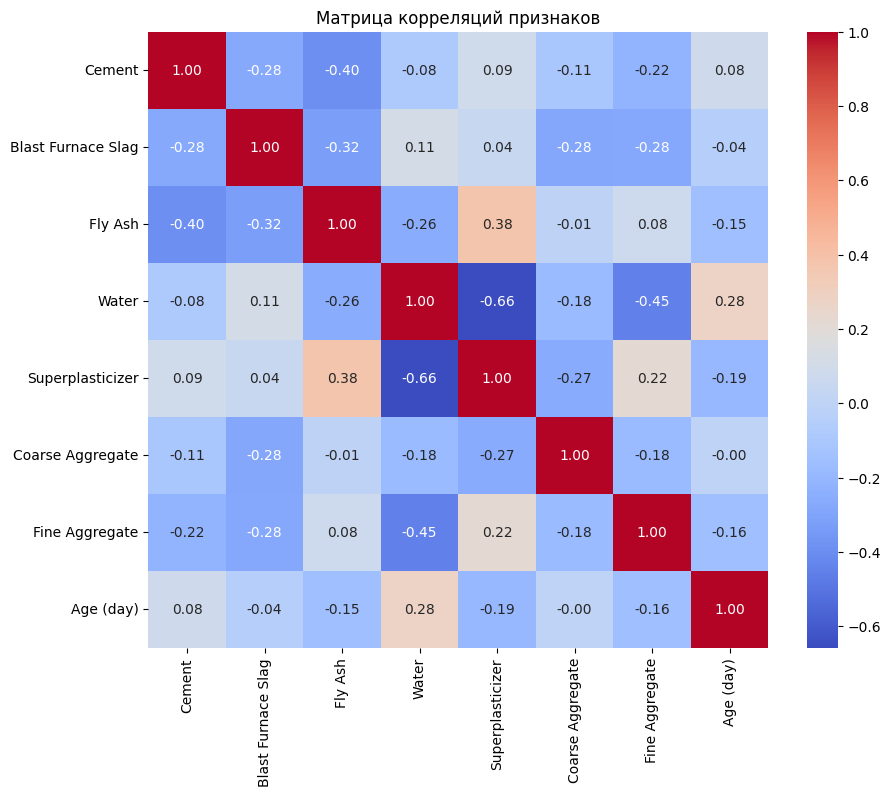

              feature        VIF
0    Coarse Aggregate  84.959460
1               Water  82.150840
2      Fine Aggregate  72.795397
3              Cement  15.468620
4    Superplasticizer   5.472391
5             Fly Ash   4.148893
6  Blast Furnace Slag   3.330359
7           Age (day)   1.699430


In [67]:
plt.figure(figsize=(10, 8))
sns.heatmap(x.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций признаков')
plt.show()

vif_data = pd.DataFrame()
vif_data["feature"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True))

Была проведена оценка мультиколлинеарности признаков с помощью коэффициента VIF (Variance Inflation Factor) и матрицы корреляций. В результате расчета VIF была выявлена мультиколлинеарность в исходных данных у признаков Water, Coarse Aggregate и Fine Aggregate значения VIF достигают 82.15, 84.96 и 72.80 соответственно, что превышает пороговое значение 10, указывающее на критический уровень линейной зависимости между переменными. Также умеренно высокий VIF наблюдается у Cement (15.47). Слабую мультиколлинеарность или её отсутствие демонстрируют Age (1.70) и Blast Furnace Slag (3.33).

### Регрессионные модели: линейная и гребневая регрессия

Для предсказания прочности бетона на сжатие в работе используются два метода линейного моделирования: **линейная регрессия** и **гребневая регрессия (Ridge Regression)**.

**Линейная регрессия** предполагает, что целевая переменная (прочность бетона) линейно зависит от входных признаков (состав смеси и возраст). Модель имеет вид:  

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p + \varepsilon$
  
где $\beta_0$ — свободный член, $\beta_1$, $\dots$, $\beta_p$ — коэффициенты, а $\varepsilon$ — ошибка.

Нужно найти такие коэффициенты $\beta_p$, чтобы ошибки предсказаний были минимальны. Используется среднеквадратичная ошибка (MSE).

Для решения этой проблемы применяется **гребневая регрессия** — метод регуляризации, который добавляет к функции потерь штраф за большие значения коэффициентов:

$\text{Loss} = \sum_{i=1}^n (y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^p \beta_j^2.$ 

Параметр $\alpha > 0$ контролирует силу регуляризации: чем он больше, тем сильнее коэффициенты «стягиваются» к нулю. Это повышает устойчивость модели и снижает переобучение, особенно в условиях мультиколлинеарности.

Обе модели оцениваются на тестовой выборке с использованием метрик **RMSE**, **R²** и **MAPE**.

**MSE** (Mean Squared Error) — средняя квадратичная ошибка; среднее значение квадратов разностей между предсказанными и истинными значениями.

**RMSE** (Root Mean Squared Error) — корень из MSE.

**MAPE** (Mean Absolute Percentage Error) — средняя абсолютная процентная ошибка; показывает среднюю ошибку в процентах от истинного значения.

**$R^2$** (коэффициент детерминации) — доля дисперсии целевой переменной, объяснённая моделью. Принимает значения от 0 до 1; чем ближе к 1 — тем лучше модель объясняет данные.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    cv_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()
    print(f"\n{name}:")
    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.4f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"CV R^2: {cv_r2:.4f}")
    return rmse, r2, mape

ridge_cv = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)

lr = LinearRegression()
ridge = Ridge(alpha=ridge_cv.alpha_)

res_lr = evaluate_model(lr, X_train, X_test, y_train, y_test, "Linear Regression")
res_ridge = evaluate_model(ridge, X_train, X_test, y_train, y_test, "Ridge Regression")


Linear Regression:
RMSE: 9.797
R^2: 0.6275
MAPE: 29.28%
CV R^2: 0.5945

Ridge Regression:
RMSE: 9.797
R^2: 0.6275
MAPE: 29.45%
CV R^2: 0.5948


Линейная и гребневая регрессии показали практически идентичные метрики качества: RMSE $\approx$ 9.80, $R^2 \approx$ 0.628, MAPE $\approx$ 29.29–29.45%, а кросс-валидация подтвердила устойчивость результатов (CV $R^2$ $\approx$ 0.595). Это свидетельствует о том, что оптимальный параметр регуляризации α в Ridge-регрессии оказался близок к нулю, и модель фактически вырождается в обычную линейную регрессию. Несмотря на наличие сильной мультиколлинеарности в исходных данных (VIF до 85), стандартизация признаков позволила линейной модели сохранить умеренную предсказательную способность. Значение $R^2$ $\approx$ 0.63 указывает на то, что модель объясняет около 63% дисперсии прочности бетона.

### Устранение мультиколлинеарности с помощью метода главных компонент

Исходное количество признаков: 8
Количество компонент после PCA: 6
Объяснённая дисперсия: 0.9740


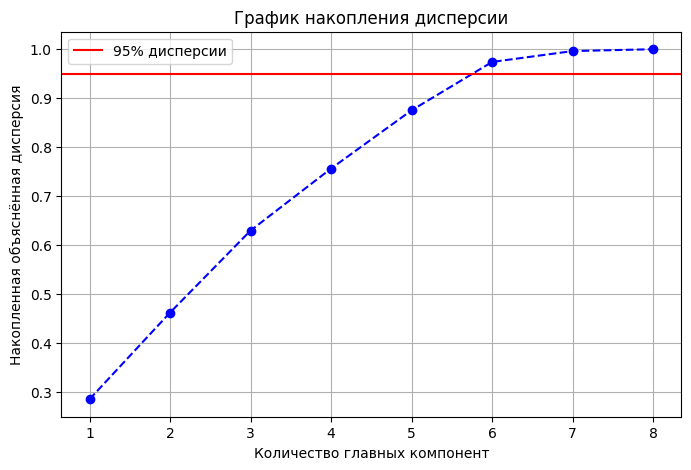

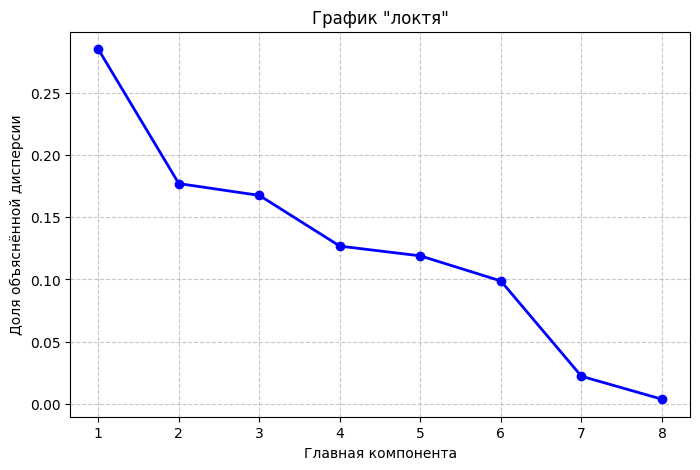

In [69]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Исходное количество признаков: {X_scaled.shape[1]}")
print(f"Количество компонент после PCA: {X_pca.shape[1]}")
print(f"Объяснённая дисперсия: {pca.explained_variance_ratio_.sum():.4f}")

pca_full = PCA()
pca_full.fit(X_scaled)

plt.figure(figsize=(8, 5))
cumsum_var = pca_full.explained_variance_ratio_.cumsum()
plt.plot(range(1, len(cumsum_var) + 1), cumsum_var, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% дисперсии')
plt.xlabel('Количество главных компонент')
plt.ylabel('Накопленная объяснённая дисперсия')
plt.title('График накопления дисперсии')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(cumsum_var) + 1))
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(pca_full.explained_variance_ratio_) + 1),
    pca_full.explained_variance_ratio_,
    'bo-',
    linewidth=2,
    markersize=6
)
plt.xlabel('Главная компонента')
plt.ylabel('Доля объяснённой дисперсии')
plt.title('График "локтя"')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
plt.show()

Исходные 8 признаков были успешно сжаты до 6 главных компонент, которые в совокупности объясняют 97.4% общей дисперсии данных. Это означает, что PCA позволил существенно снизить размерность при минимальной потере информации.

График накопленной дисперсии показывает плавный рост, после 6 компонент рост снижается, а накопленная дисперсия пререходит порог 95%, что подтверждает целесообразность выбора именно этого числа. График локтя демонстрирует постепенное убывание вклада каждой последующей компоненты явный изгиб отсутствует, что указывает на равномерное распределение информации между компонентами, а не на доминирование одной или двух.

Таким образом, PCA не только устранил мультиколлинеарност, но и сохранил практически всю полезную информацию для моделирования. Снижение размерности с 8 до 6 признаков также способствует ускорению обучения моделей.

In [70]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

res_lr = evaluate_model(lr, X_train, X_test, y_train, y_test, "Linear Regression")
res_ridge = evaluate_model(ridge, X_train, X_test, y_train, y_test, "Ridge Regression")

res_lr_pac = evaluate_model(LinearRegression(), X_train_pca, X_test_pca, y_train, y_test, "Linear Regression (PCA)")
res_ridge_pac = evaluate_model(Ridge(alpha=1.0), X_train_pca, X_test_pca, y_train, y_test, "Ridge Regression (PCA)")


Linear Regression:
RMSE: 9.797
R^2: 0.6275
MAPE: 29.28%
CV R^2: 0.5945

Ridge Regression:
RMSE: 9.797
R^2: 0.6275
MAPE: 29.45%
CV R^2: 0.5948

Linear Regression (PCA):
RMSE: 10.537
R^2: 0.5691
MAPE: 32.55%
CV R^2: 0.5525

Ridge Regression (PCA):
RMSE: 10.537
R^2: 0.5691
MAPE: 32.58%
CV R^2: 0.5525


После PCA качество моделей снизилось, что объясняется потерей части информации из-за снижения размерности. Однако PCA полностью устранил мультиколлинеарность, что делает коэффициенты моделей более стабильными. В подтверждение этому далее будет представлена матрица корреляций главных компонент.

### Матрица корреляций главных компонент

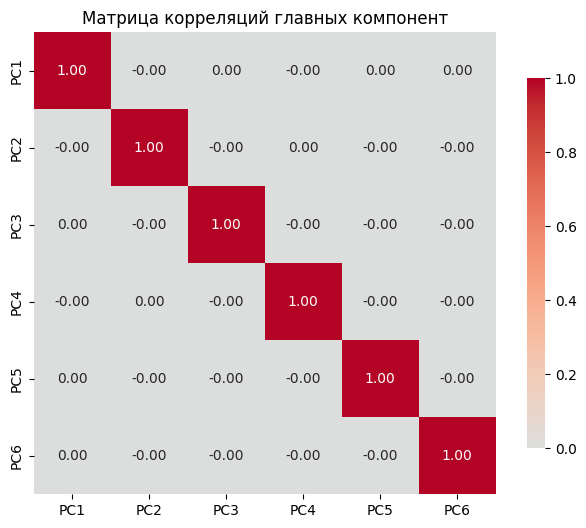

In [71]:
pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_columns)

corr_matrix_pca = df_pca.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_pca, 
            annot=True, 
            cmap='coolwarm', 
            center=0, 
            square=True,
            fmt=".2f",
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций главных компонент')
plt.show() 

### Заключение
В ходе исследования была решена задача предсказания прочности бетона на сжатие. Анализ данных показал, что датасет полный, не содержит пропущенных значений, но при этом характеризуется сильной мультиколлинеарностью между признаками (VIF до 85). Распределения большинства признаков умеренно или сильно смещены.

Были построены и сравнены две регрессионные модели - линейная и гребневая регрессия. Обе показали схожее качество RMSE $\approx$ 9.80, $R^2 \approx$ 0.628, MAPE $\approx$ 29.29–29.45% , что свидетельствует о приемлемой предсказательной способности.

Для устранения мультиколлинеарности был применён метод главных компонент (PCA), который сократил размерность с 8 до 6 компонент при сохранении 97.4% дисперсии и полностью устранил корреляции между признаками. Однако модели на главных компонентах показали ухудшение качества ($R^2$ $\approx$ 0.569, RMSE $\approx$ 10.537), что указывает на потерю информации.